# Time series regression attempt

## Data: alcohol [sales](https://www.kaggle.com/datasets/bulentsiyah/for-simple-exercises-time-series-forecasting?resource=download&select=BeerWineLiquor.csv)

In [78]:
import numpy as np
import pandas as pd
from deap import base, tools, creator
import seaborn as sns

beer = pd.read_csv("data/BeerWineLiquor.csv")
# The data is based on the 1st day of each month. Therefore, we can get rid of the day column and keep month and year numeric
beer["month"] = beer.apply(lambda row: row.date.split("/")[0], axis=1)
beer["year"] = beer.apply(lambda row: row.date.split("/")[2], axis=1)
del beer["date"]
beer.head()

,beer,month,year
0,1509,1,1992
1,1541,2,1992
2,1597,3,1992
3,1675,4,1992
4,1822,5,1992


<Axes: ylabel='beer'>

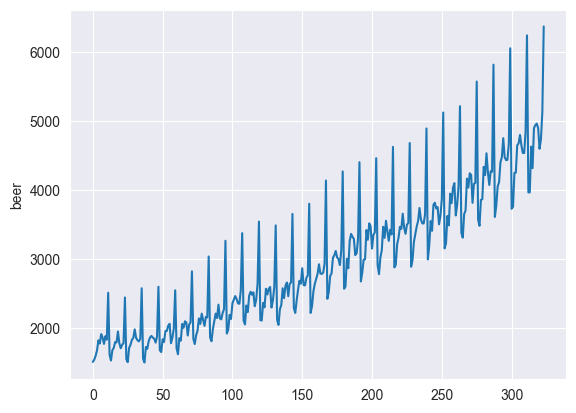

In [9]:
sns.lineplot(beer["beer"])

In [79]:
from sklearn.model_selection import train_test_split

X = beer.drop("beer", axis=1)
y = beer["beer"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [92]:
import random

N_WEIGHTS_PLUS_INTERCEPT = len(X_train.columns) + 1

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_float,
    N_WEIGHTS_PLUS_INTERCEPT,
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def prediction(individual, row):
    regr = individual[0] + sum([i * float(r) for i, r in zip(individual[1:3], row)])
    return float(regr)


def eval_mse(individual, X=X_train, y=y_train):
    y_pred = [None] * X.shape[0]

    index = 0
    for i, row in X.iterrows():
        y_pred[index] = prediction(individual, row)
        index += 1

    # calculate mean squared difference (using the training set)
    diff = (np.array(y_pred) - np.array(y)) ** 2
    return (np.mean(diff),)


toolbox.register("evaluate", eval_mse, X=X_train, y=y_train)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.4, indpb=0.4)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("select", tools.selTournament, tournsize=3)

/Users/ivanbar/Library/Python/3.9/lib/python/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/ivanbar/Library/Python/3.9/lib/python/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [93]:
from deap import algorithms

NGEN = 250
CXPB = 0.5
MUTPB = 0.2
popSize = MU = 200
LAMBDA = 400
pop = toolbox.population(n=100)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
pop, log = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats)

gen	nevals	avg                	std               	min               	max                
0  	100   	[10685108.74684997]	[6884961.90786774]	[1859695.77158222]	[25171920.40155754]
1  	290   	[5044000.40581185] 	[3598299.80203795]	[1470340.00416189]	[19210421.16829012]
2  	267   	[2599920.15799002] 	[1198859.89006068]	[1046082.71222591]	[11424398.68968941]
3  	271   	[1840599.98003799] 	[444137.19964078] 	[980160.39349003] 	[3391578.13581909] 
4  	293   	[1441141.93785832] 	[356798.74441746] 	[980077.00855508] 	[2271280.75563337] 
5  	279   	[1125763.23691098] 	[167743.8969569]  	[976278.48031376] 	[1881291.2717687]  
6  	280   	[1035416.60094373] 	[38116.75897225]  	[975773.24460418] 	[1173026.37795154] 
7  	283   	[1010234.54035447] 	[30961.19839317]  	[974742.53596809] 	[1051189.9089808]  
8  	271   	[988964.06547712]  	[23470.22726116]  	[972778.4861752]  	[1046082.71222591] 
9  	280   	[976662.39129981]  	[5079.12741056]   	[972778.4861752]  	[1028365.97926199] 
10 	256   	[974855.19

65 65


<Axes: ylabel='beer'>

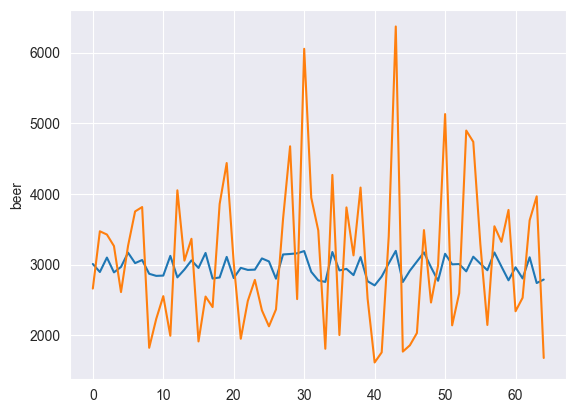

In [94]:
y_pred = [None] * X_test.shape[0]

index = 0
for i, row in X_test.iterrows():
    y_pred[index] = prediction(tools.selBest(pop, 1)[0], row)
    index += 1
print(len(y_pred), len(y_test))
sns.lineplot(x=np.arange(len(y_test)), y=y_pred)
sns.lineplot(x=np.arange(len(y_test)), y=y_test)